# Correlation Analysis
---

In this notebook we are interested in discovering if there is a relationship between the media coverage (by the newspapers) partitionned by positive and negative quotes and the voting intention (for the elections of 2012, 2016 and 2020) and what kind relationship it is, in order to gain insights and form our conclusion. 
This is a similar notebook to [this one](correlation_analysis.ipynb) but with polarity as an additionnal dimension.

In [1]:
import itertools
from datetime import datetime
from itertools import combinations_with_replacement

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



## Preprocessing
***

In [2]:
def cast_to_datetime(df, col):
    return df[col].astype("datetime64[ns]")


def cast_to_datetime_all(df_polls, candidates, newspapers, candidates_name):
    df_polls["Date_start"] = cast_to_datetime(df_polls, "Date_start")
    df_polls["Date_end"] = cast_to_datetime(df_polls, "Date_end")

    for df_candidate in candidates:
        df_candidate["date"] = cast_to_datetime(df_candidate, "date")

    for df_newspaper in newspapers:
        df_newspaper["date"] = cast_to_datetime(df_newspaper, "date")

    return {"polls": df_polls, "candidates": candidates, "newspapers": newspapers, "names": candidates_name}


def partition_quotes_by_polarity(df, threshold=0):
    """
    Separate negative quotes from positive quotes and return them as a pair.
    :param df: dataframe with ['quotation_polarity] column
    :param threshold: with which to consider negative/positive
    :return: spited dataframe by positive/negative quotes
    """
    return df[df['quotation_polarity'] > threshold], df[df['quotation_polarity'] < threshold]

In [3]:
# Change to false if you don't want to load a certain year
flag_2012 = True
flag_2016 = True
flag_2020 = True

## Load data
PATH_2012 = "../Data/2012/"
PATH_2016 = "../Data/2016/"
PATH_2020 = "../Data/2020/"
PATH_PREPROCESSED = "../Data/preprocessed/"

data = []

if flag_2012:
    df_polls_2012 = pd.read_csv(PATH_PREPROCESSED + "polls_2012.csv")

    df_sentiment_obama_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_obama_2012.csv")
    df_sentiment_romney_2012 = pd.read_csv(PATH_PREPROCESSED + "sentiment_romney_2012.csv")

    df_sentiment_obama_2012_pos, df_sentiment_obama_2012_neg = partition_quotes_by_polarity(df_sentiment_obama_2012)
    df_sentiment_romney_2012_pos, df_sentiment_romney_2012_neg = partition_quotes_by_polarity(df_sentiment_romney_2012)

    candidates_2012 = [df_sentiment_obama_2012_pos, df_sentiment_romney_2012_pos, df_sentiment_obama_2012_neg,
                       df_sentiment_romney_2012_neg]

    df_bbc_2012 = pd.read_csv(PATH_2012 + "bbc_2012.zip")
    df_foxnews_2012 = pd.read_csv(PATH_2012 + "foxnews_2012.zip")
    df_nytimes_2012 = pd.read_csv(PATH_2012 + "ny_times_2012.zip")

    newspaper_2012 = [df_bbc_2012, df_foxnews_2012, df_nytimes_2012]

    data.append(("2012", cast_to_datetime_all(df_polls_2012, candidates_2012, newspaper_2012,
                                              ["Obama (+)", "Romney (+)", "Obama (-)", "Romney (-)"])))

if flag_2016:
    df_polls_2016 = pd.read_csv(PATH_PREPROCESSED + "polls_2016.csv")

    df_sentiment_clinton_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_clinton_2016.csv")
    df_sentiment_trump_2016 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2016.csv")

    df_sentiment_clinton_2016_pos, df_sentiment_clinton_2016_neg = partition_quotes_by_polarity(df_sentiment_clinton_2016)
    df_sentiment_trump_2016_pos, df_sentiment_trump_2016_neg = partition_quotes_by_polarity(df_sentiment_trump_2016)

    candidates_2016 = [df_sentiment_clinton_2016, df_sentiment_trump_2016_pos, df_sentiment_clinton_2016_neg, df_sentiment_trump_2016_neg]

    df_bbc_2016 = pd.read_csv(PATH_2016 + "bbc_2016.zip")
    df_foxnews_2016 = pd.read_csv(PATH_2016 + "foxnews_2016.zip")
    df_nytimes_2016 = pd.read_csv(PATH_2016 + "ny_times_2016.zip")

    newspaper_2016 = [df_bbc_2016, df_foxnews_2016, df_nytimes_2016]

    data.append(("2016", cast_to_datetime_all(df_polls_2016, candidates_2016, newspaper_2016, ["Clinton (+)", "Trump (+)", "Clinton (-)", "Trump (-)"])))

if flag_2020:
    df_polls_2020 = pd.read_csv(PATH_PREPROCESSED + "polls_2020.csv")

    df_sentiment_biden_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_biden_2020.csv")
    df_sentiment_trump_2020 = pd.read_csv(PATH_PREPROCESSED + "sentiment_trump_2020.csv")

    df_sentiment_biden_2020_pos, df_sentiment_biden_2020_neg = partition_quotes_by_polarity(df_sentiment_biden_2020)
    df_sentiment_trump_2020_pos, df_sentiment_trump_2020_neg = partition_quotes_by_polarity(df_sentiment_trump_2020)

    candidates_2020 = [df_sentiment_biden_2020_pos, df_sentiment_trump_2020_pos, df_sentiment_biden_2020_neg, df_sentiment_trump_2020_neg]

    df_bbc_2020 = pd.read_csv(PATH_2020 + "bbc_2020.zip")
    df_foxnews_2020 = pd.read_csv(PATH_2020 + "foxnews_2020.zip")
    df_nytimes_2020 = pd.read_csv(PATH_2020 + "ny_times_2020.zip")

    newspaper_2020 = [df_bbc_2020, df_foxnews_2020, df_nytimes_2020]

    data.append(("2020", cast_to_datetime_all(df_polls_2020, candidates_2020, newspaper_2020, ["Biden (+)", "Trump (+)", "Biden (-)", "Trump (-)"])))

/var/folders/jq/7zcpzzn172l6vd52l226wlk40000gn/T/ipykernel_63638/3825389671.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candidate["date"] = cast_to_datetime(df_candidate, "date")


### Aggregation

In [4]:
def check_columns(newspaper, df_newspaper, df_candidate):
    check = True

    if "date" not in df_newspaper.columns:
        print("Error: missing 'date' column in df_newspaper")
        check = False

    if "date" not in df_candidate.columns:
        print("Error: missing 'date' column in df_candidate")
        check = False

    if "type" not in df_candidate.columns:
        print("Error: missing 'type' column in df_candidate")
        check = False
    elif newspaper not in df_candidate.type.unique():
        print(f"Error: newspaper '{newspaper}' is not in the list of newspapers")
        check = False

    return check;


def aggregate_by_week(df, col, operation):
    df = df.sort_values("date")
    df.loc[:, "week"] = df.loc[:, "date"].dt.strftime("%U")
    df_weekly_occurrences = df.groupby("week", as_index=False).agg({col: operation}).rename(
        columns={col: f"{col}_{operation}"})
    df_weekly_occurrences["week"] = df_weekly_occurrences["week"].astype("int64")

    return df_weekly_occurrences


def merge_occurrences(df_newspaper_occurrences, df_candidate_occurrences):
    df_counts = df_newspaper_occurrences.set_index("week").join(
        df_candidate_occurrences.set_index("week"),
        on="week",
        how="left",
        lsuffix="_newspaper",
        rsuffix="_candidate",
    )

    df_counts = df_counts[["date_count_newspaper", "date_count_candidate"]]
    df_counts["weekly_occurrences_rescaled"] = (df_counts["date_count_candidate"] / df_counts["date_count_newspaper"])

    return df_counts


def compute_weekly_rescaled_occurences_intention(newspaper, df_newspaper, df_candidate, df_polls, intention_idx=0, keep_weeks='all'):
    intention_idx = intention_idx % 2
    candidate = df_polls.columns[4 + intention_idx]

    print(f"Candidate: {candidate}, newspaper: {newspaper}")

    df_polls = df_polls.rename(columns={"Date_end": "date", df_polls.columns[4 + intention_idx]: "intention"})

    if not check_columns(newspaper, df_newspaper, df_candidate):
        return

    df_newspaper_weekly_occurrences = aggregate_by_week(df_newspaper, "date", "count")
    df_candidate_weekly_occurrences = aggregate_by_week(df_candidate[df_candidate.type == newspaper], "date", "count")
    df_intention_weekly_averaged = aggregate_by_week(df_polls, "intention", "mean")
    df_counts = merge_occurrences(df_newspaper_weekly_occurrences, df_candidate_weekly_occurrences)

    df_occurrences_intention = df_counts.join(
        df_intention_weekly_averaged.set_index("week"),
        on="week",
        how="inner",
    )

    if keep_weeks != "all":
        keep_weeks = list(set(keep_weeks).intersection(set(df_occurrences_intention.index)))
        df_occurrences_intention = df_occurrences_intention.loc[keep_weeks, :]

    print(keep_weeks)

    return df_occurrences_intention[["weekly_occurrences_rescaled", "intention_mean"]].rename_axis('week').reset_index()

In [5]:
dict_wroi = {}

for year in data:
    for intention_idx in [0, 1, 2, 3]:
        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]

            condidate_name = year[1]["names"][intention_idx]

            keep_weeks = "all"

            if year[0] == "2016":
                start_dt = datetime(2016, 7, 1)
                end_dt = datetime(2016, 9, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))
            elif year[0] == "2020":
                start_dt = datetime(2020, 1, 1)
                end_dt = datetime(2020, 4, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]

            dict_wroi[
                (year[0], condidate_name, newspaper_name)
            ] = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
                keep_weeks
            )

dict_wroi

Candidate: Obama (D), newspaper: BBC
all
Candidate: Obama (D), newspaper: Fox News
all
Candidate: Obama (D), newspaper: NY Times
all
Candidate: Romney (R), newspaper: BBC
all
Candidate: Romney (R), newspaper: Fox News
all
Candidate: Romney (R), newspaper: NY Times
all
Candidate: Obama (D), newspaper: BBC
all
Candidate: Obama (D), newspaper: Fox News
all
Candidate: Obama (D), newspaper: NY Times
all
Candidate: Romney (R), newspaper: BBC
all
Candidate: Romney (R), newspaper: Fox News
all
Candidate: Romney (R), newspaper: NY Times
all
Candidate: Clinton (D), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Clinton (D), newspaper: NY Times
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: BBC
[32, 33, 34, 35, 36, 37, 38, 39, 26, 27, 28, 29, 30, 31]
Candidate: Trump (R), newspaper: Fox News
[32, 33, 34, 35, 36, 37, 38,

{('2012',
  'Obama (+)',
  'BBC'):     week  weekly_occurrences_rescaled  intention_mean
 0      1                     0.002692       45.033333
 1      2                     0.004915       47.000000
 2      3                     0.001187       46.857143
 3      4                     0.003007       48.500000
 4      5                     0.001612       47.666667
 5      6                     0.001775       48.250000
 6      7                     0.001862       48.444444
 7      8                     0.000848       48.600000
 8      9                     0.002659       49.500000
 9     10                     0.002842       44.666667
 10    11                     0.005424       47.888889
 11    12                     0.000944       46.000000
 12    13                     0.004001       49.666667
 13    14                     0.000707       46.000000
 14    15                     0.004794       47.125000
 15    16                     0.001789       47.636364
 16    17                     0

In [6]:
df_all = pd.DataFrame()
week_count = 0

for year in data:
    for intention_idx in [0, 1]:
        newspaper_count = 0

        for newspaper_idx in [0, 1, 2]:
            df_polls = year[1]["polls"]

            df_candidate = year[1]["candidates"][intention_idx]
            condidate_name = year[1]["names"][intention_idx]

            df_newspaper = year[1]["newspapers"][newspaper_idx]
            newspaper_name = ["BBC", "Fox News", "NY Times"][newspaper_idx]

            keep_weeks = "all"

            if year[0] == "2016":
                start_dt = datetime(2016, 7, 1)
                end_dt = datetime(2016, 9, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))
            elif year[0] == "2020":
                start_dt = datetime(2020, 1, 1)
                end_dt = datetime(2020, 4, 30)
                keep_weeks = list(range(int(start_dt.strftime("%U")), int(end_dt.strftime("%U"))+1))

            df_temp = compute_weekly_rescaled_occurences_intention(
                newspaper_name,
                df_newspaper[["date"]],
                df_candidate[["type", "date"]],
                df_polls,
                intention_idx,
            )

            if week_count == 0:
                df_all["week"] = df_temp["week"]
                week_count += 1

            if newspaper_count == 0:
                df_all[f"intention_mean_{year[0]}_{condidate_name}"] = df_temp["intention_mean"]

            df_all[f"wor_{year[0]}_{condidate_name}_{newspaper_name}"] = df_temp["weekly_occurrences_rescaled"]

# Save data
# df_all.to_csv(f"Data\preprocessed\weekly_rescaled_occurences_intention.csv", index=False) 

# Load data
# PATH_PREPROCESSED = "Data\\preprocessed\\"
# df_all = pd.read_csv(PATH_PREPROCESSED + "weekly_rescaled_occurences_intention.csv")
# df_all.columns

Candidate: Obama (D), newspaper: BBC
all
Candidate: Obama (D), newspaper: Fox News
all
Candidate: Obama (D), newspaper: NY Times
all
Candidate: Romney (R), newspaper: BBC
all
Candidate: Romney (R), newspaper: Fox News
all
Candidate: Romney (R), newspaper: NY Times
all
Candidate: Clinton (D), newspaper: BBC
all
Candidate: Clinton (D), newspaper: Fox News
all
Candidate: Clinton (D), newspaper: NY Times
all
Candidate: Trump (R), newspaper: BBC
all
Candidate: Trump (R), newspaper: Fox News
all
Candidate: Trump (R), newspaper: NY Times
all
Candidate: Biden (D), newspaper: BBC
all
Candidate: Biden (D), newspaper: Fox News
all
Candidate: Biden (D), newspaper: NY Times
all
Candidate: Trump (R), newspaper: BBC
all
Candidate: Trump (R), newspaper: Fox News
all
Candidate: Trump (R), newspaper: NY Times
all


## Regression Analysis
---

In [7]:
def baseline_model(df):
    df = df.dropna()

    col1 = 'weekly_occurrences_rescaled'
    col2 = 'intention_mean'

    spear_corr, spear_p = stats.spearmanr(df[col1], df[col2])

    return {"Spearmanr": spear_corr, "P-value": spear_p}


def plot_combination(y_var, title):
    sns.set(font_scale=1.2)
    ax = sns.catplot(data=df_correlation, x="Candidate", y=y_var, col="Year", kind="bar", hue="Newspaper", sharex=False)
    ax.fig.subplots_adjust(top=0.8)  # adjust the Figure in rp
    ax.fig.suptitle(title, fontsize=20)
    plt.show()


def linear_regresion_model(df, formula):
    mod = smf.ols(
        formula=formula,
        data=df.dropna(),
    )
    res = mod.fit()
    print(res.summary())

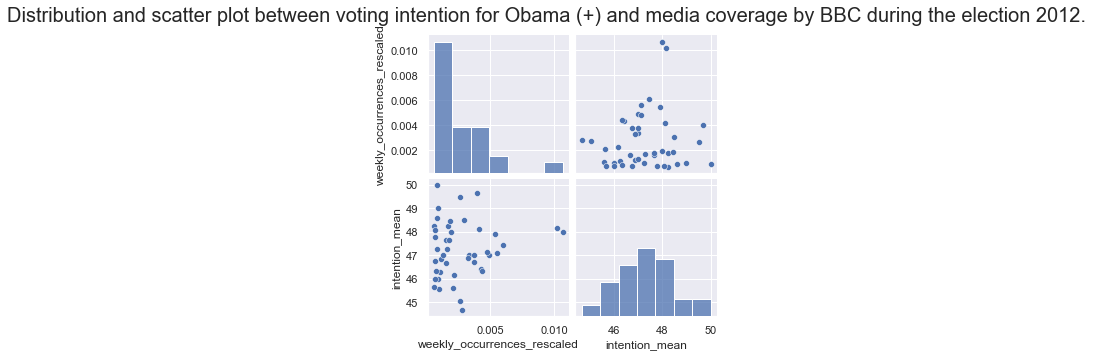

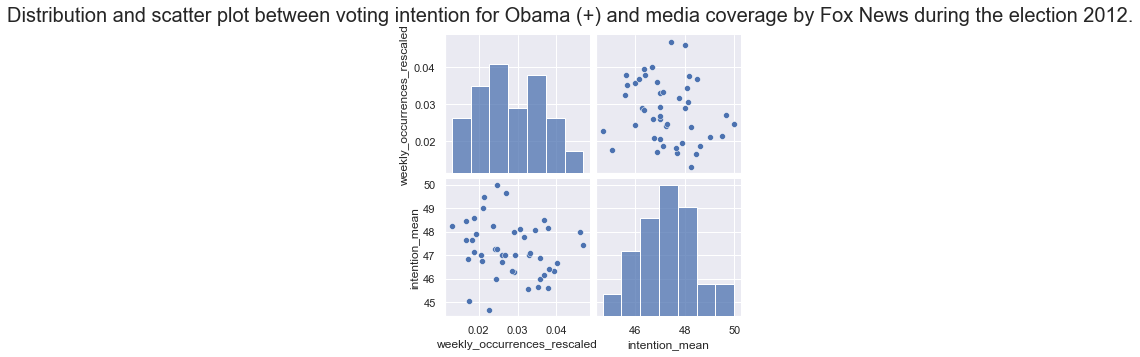

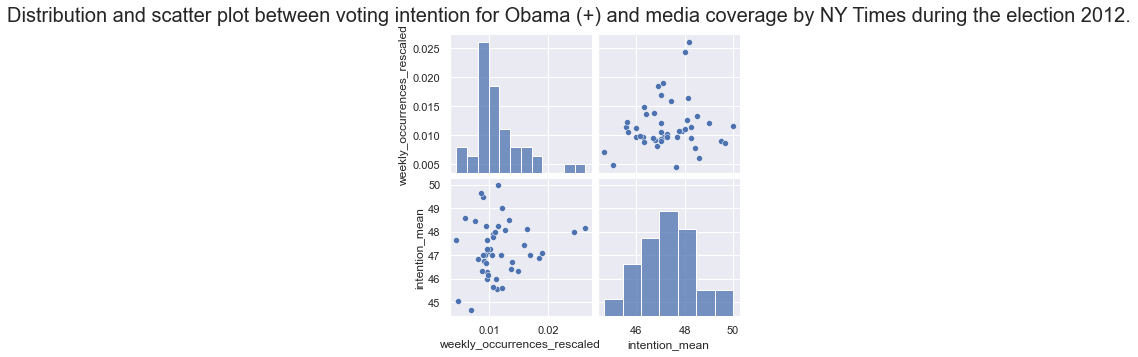

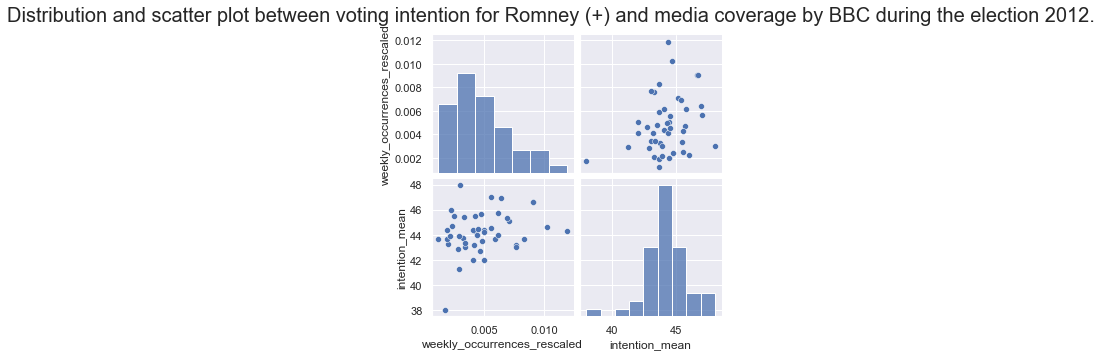

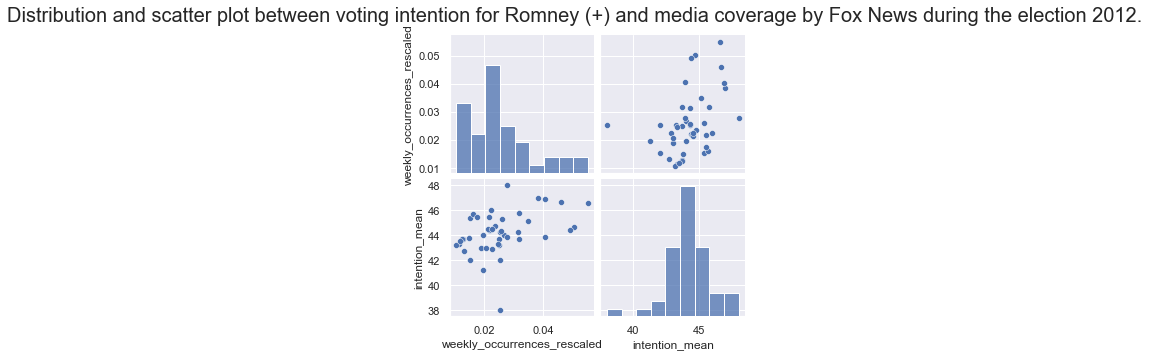

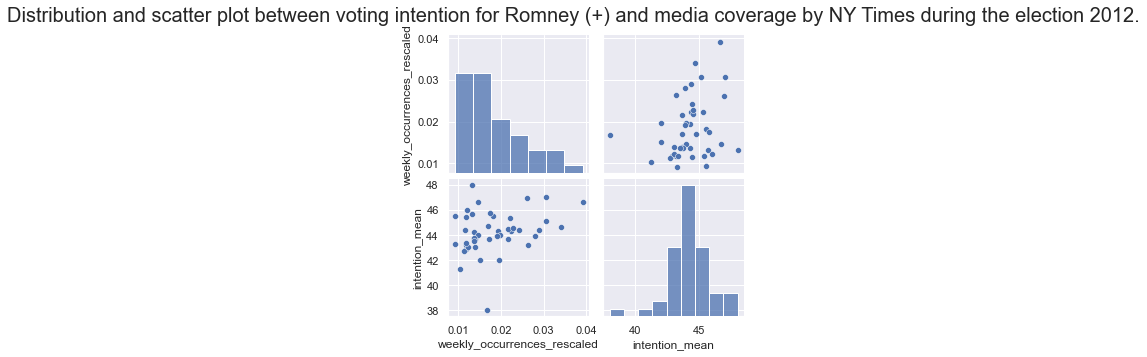

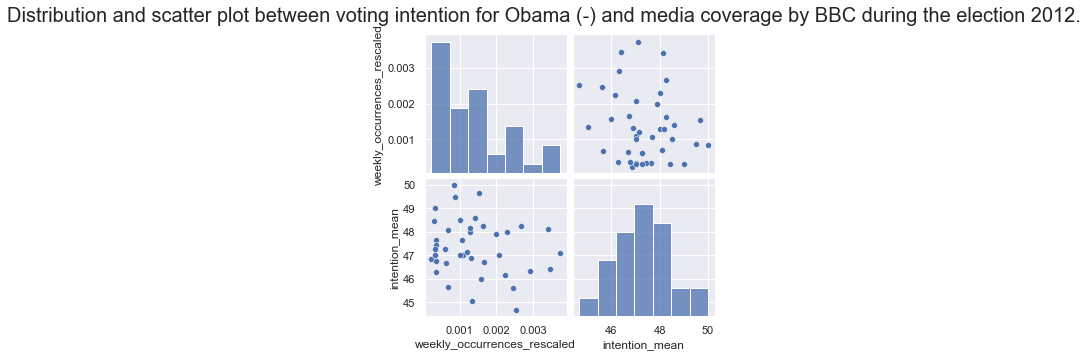

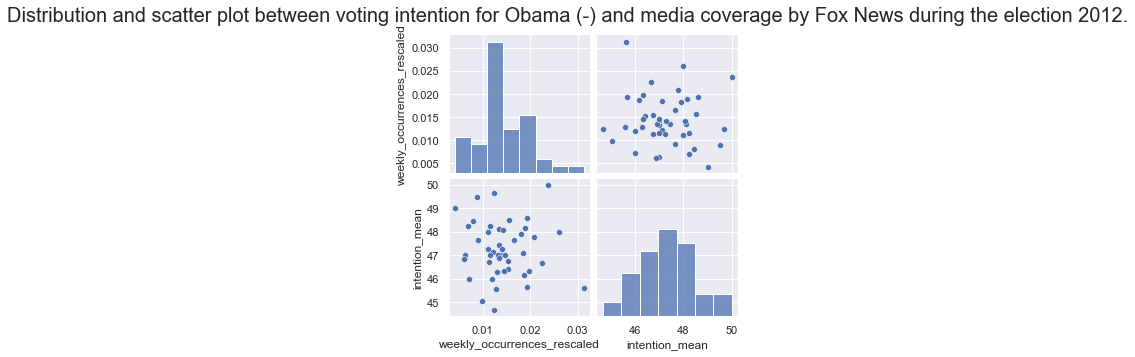

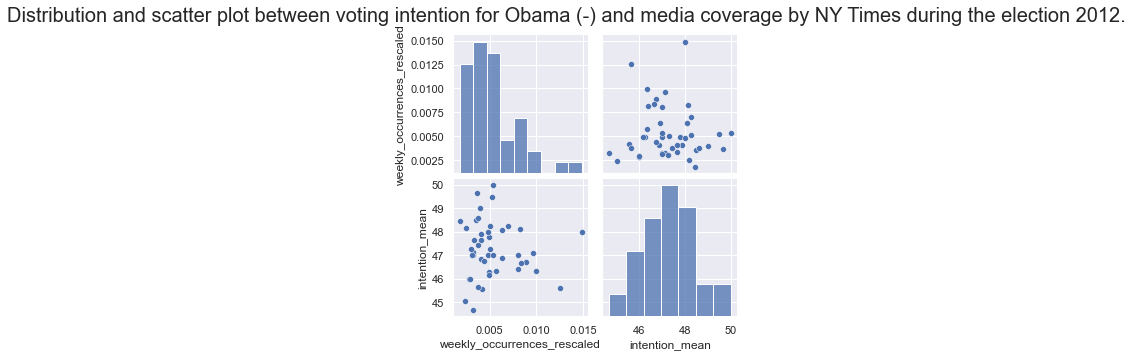

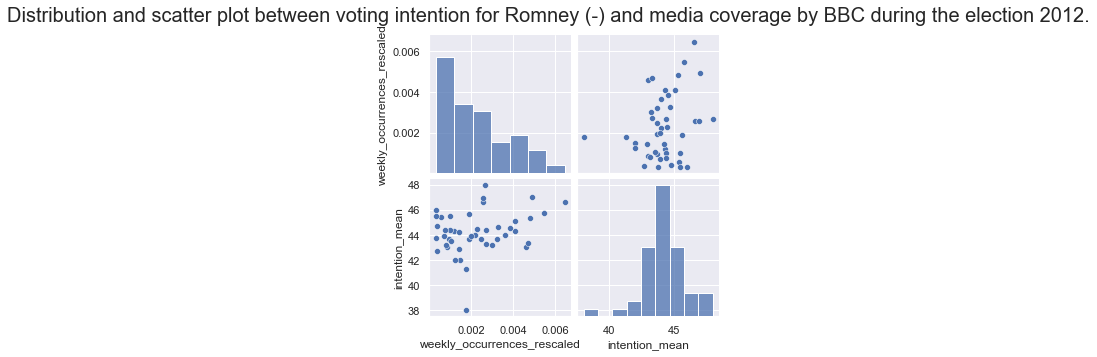

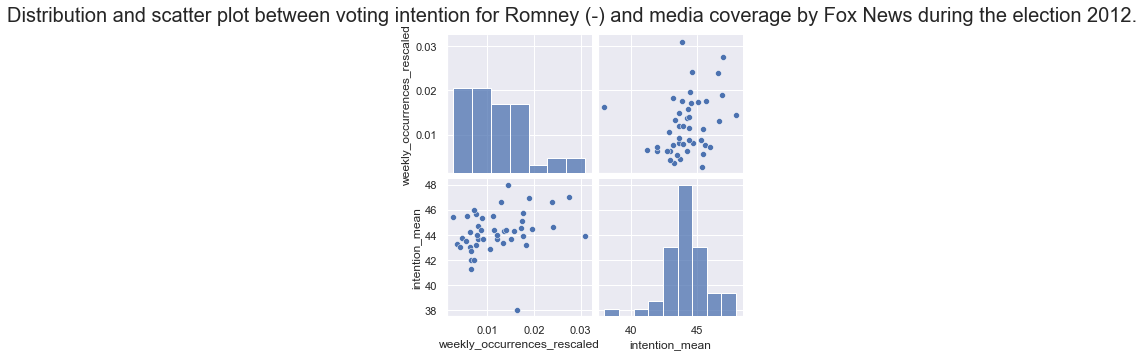

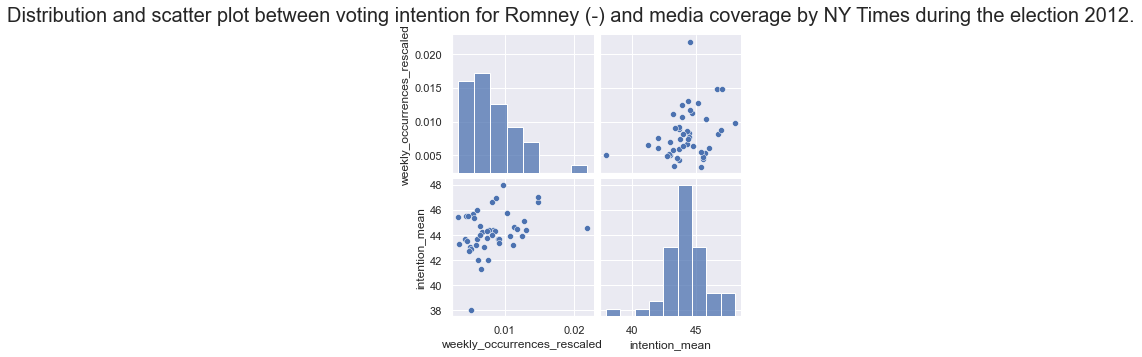

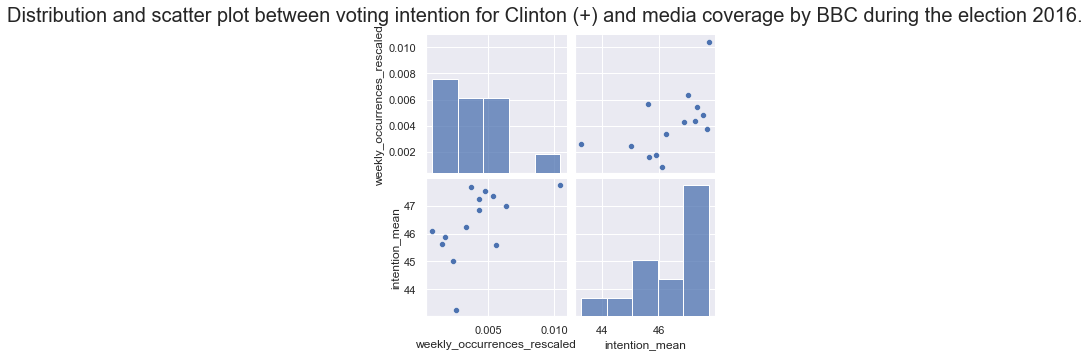

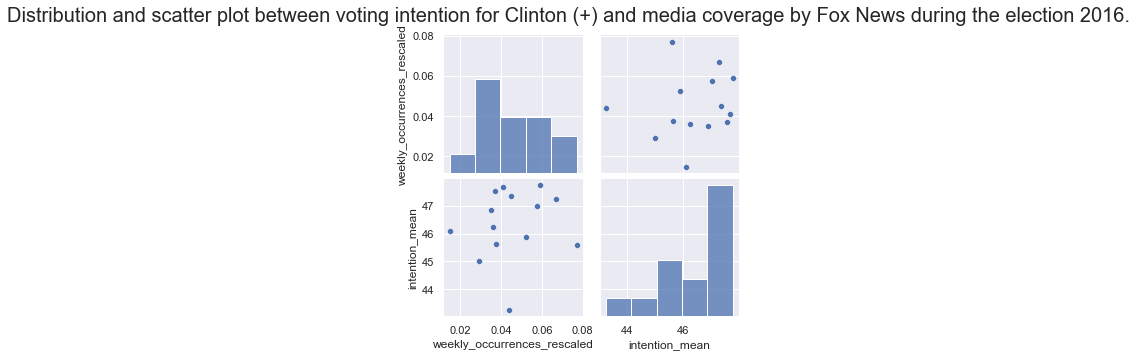

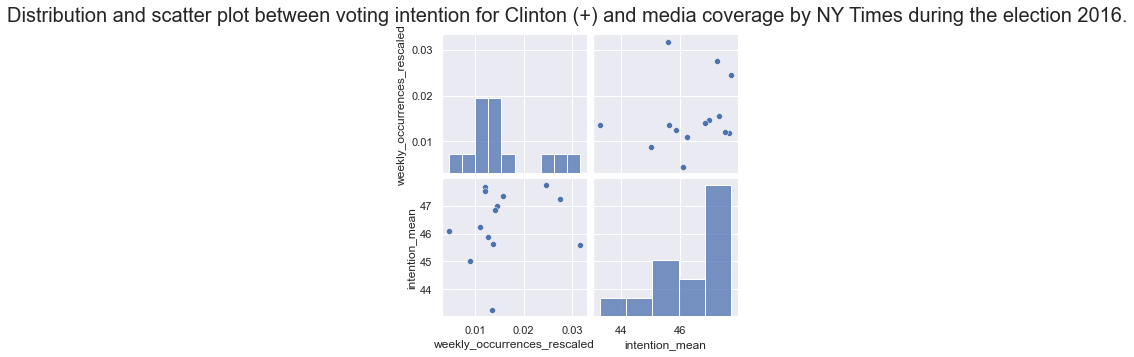

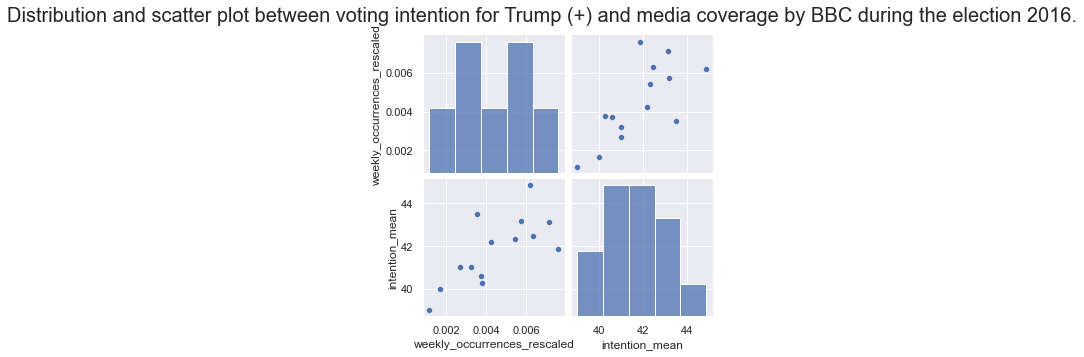

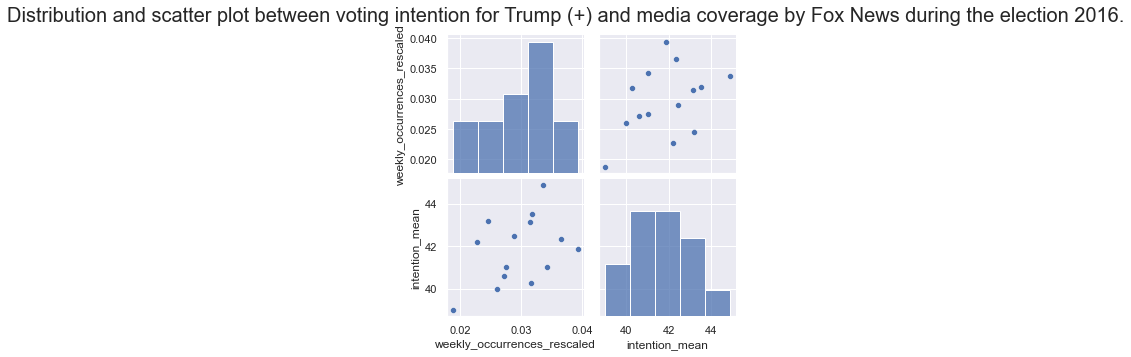

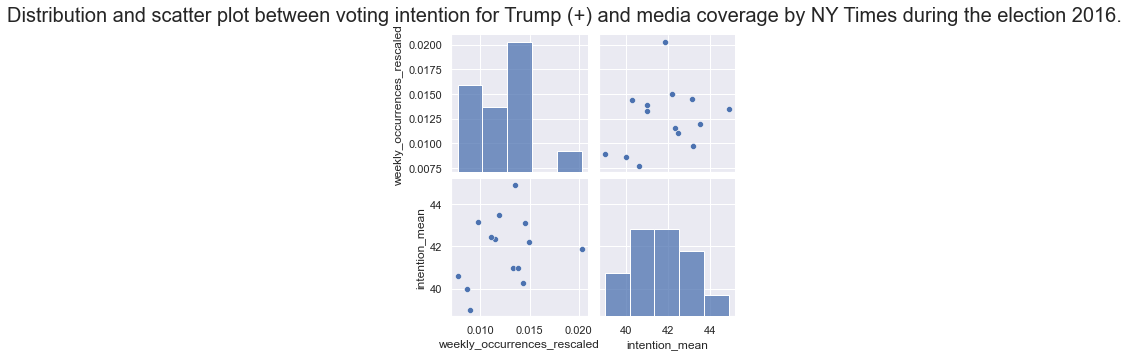

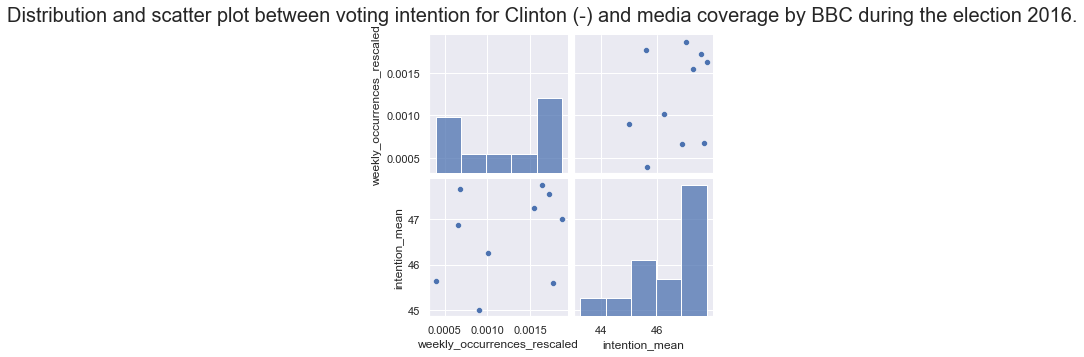

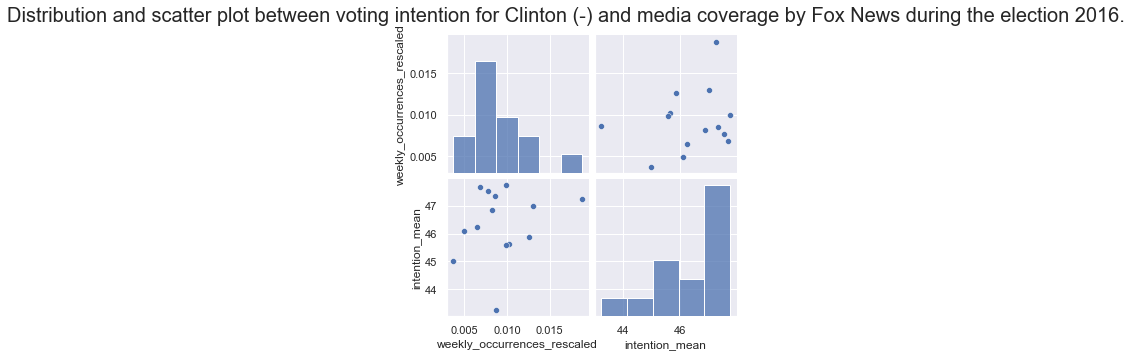

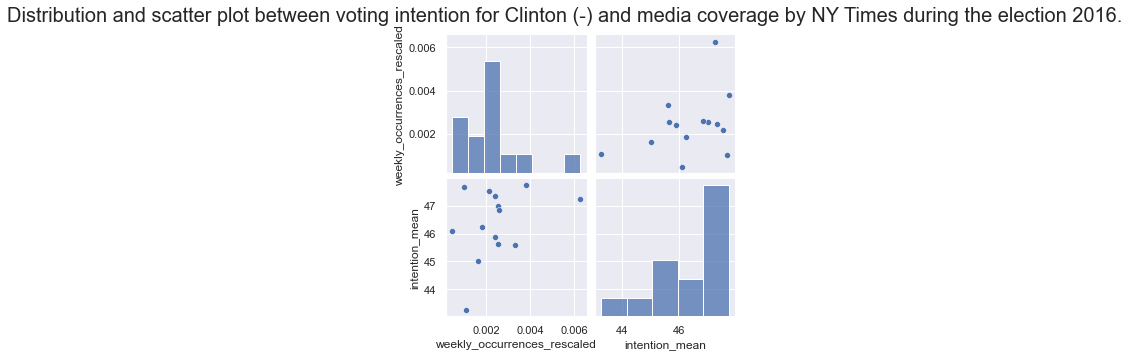

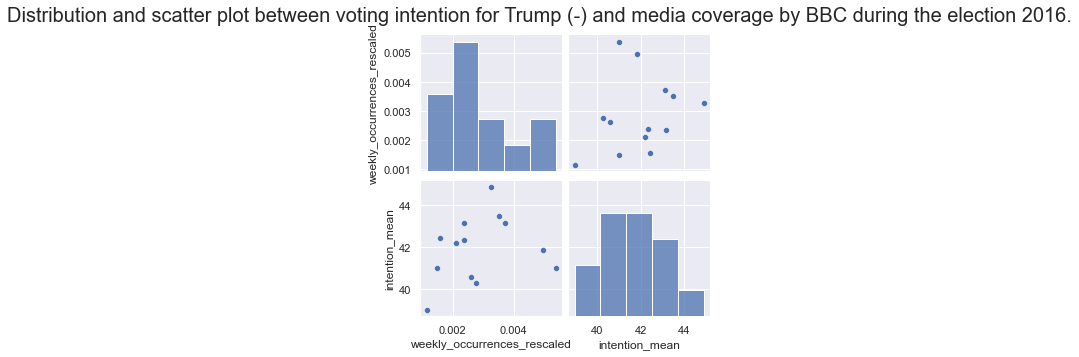

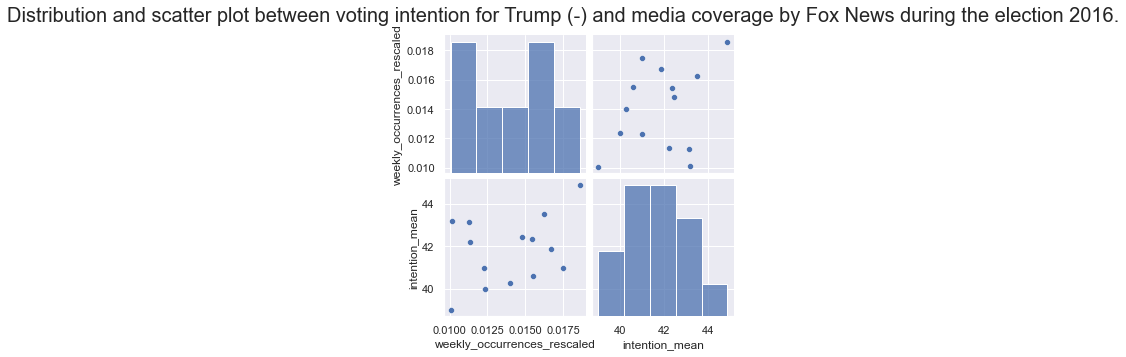

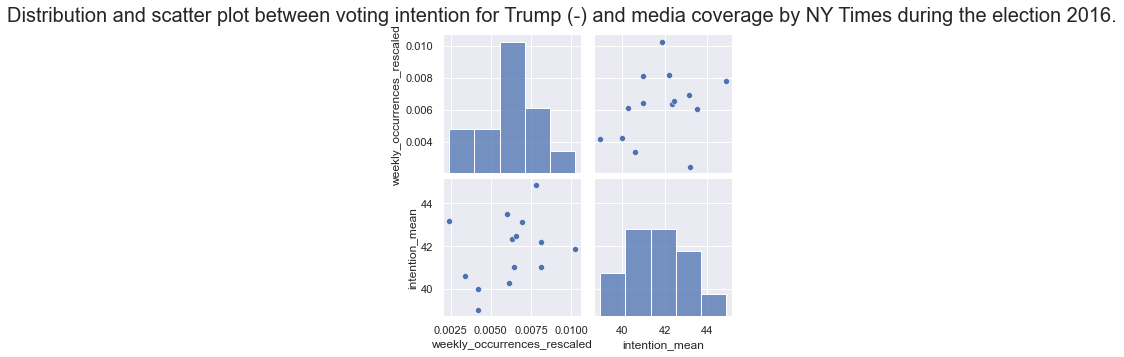

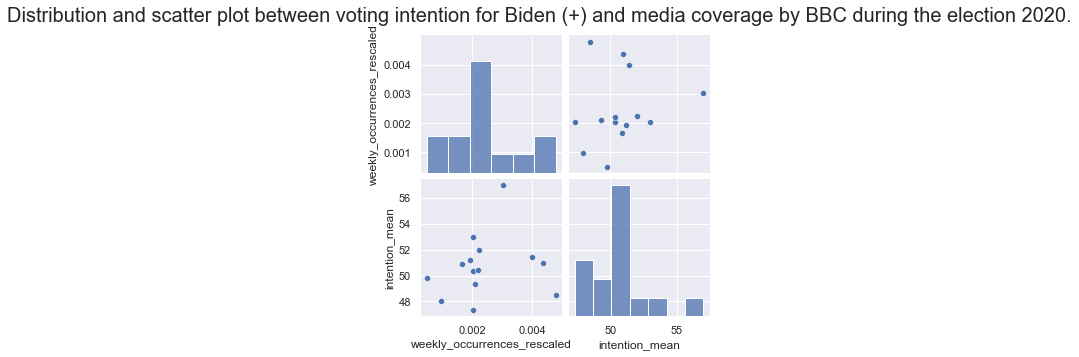

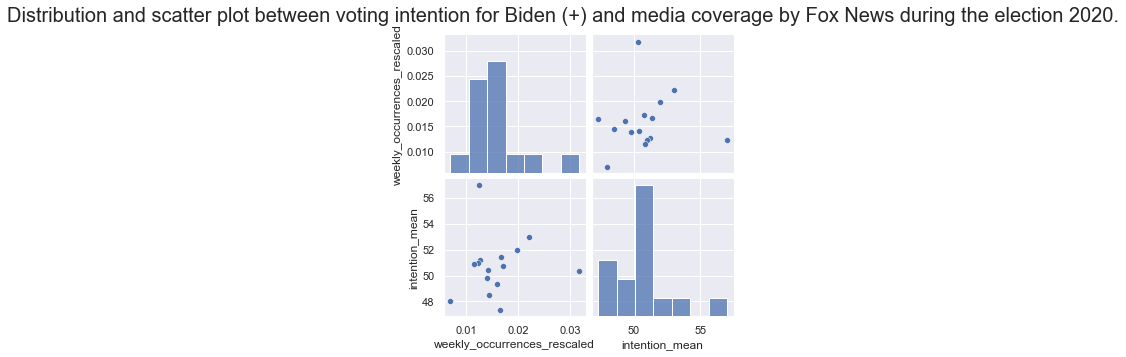

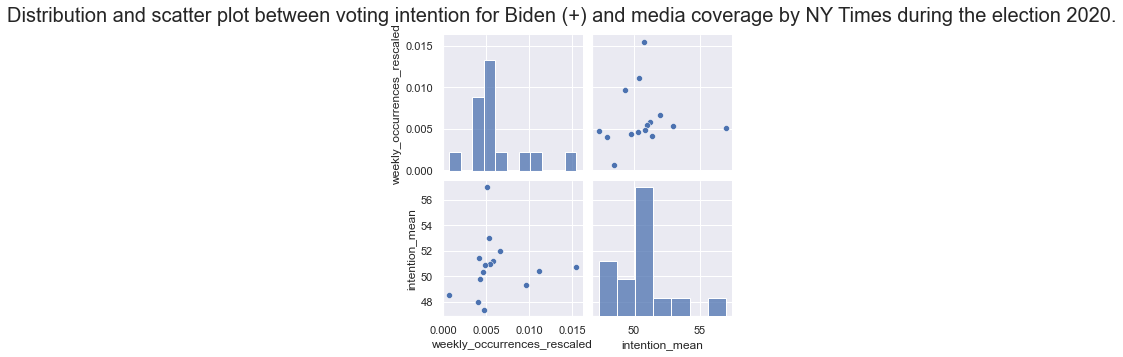

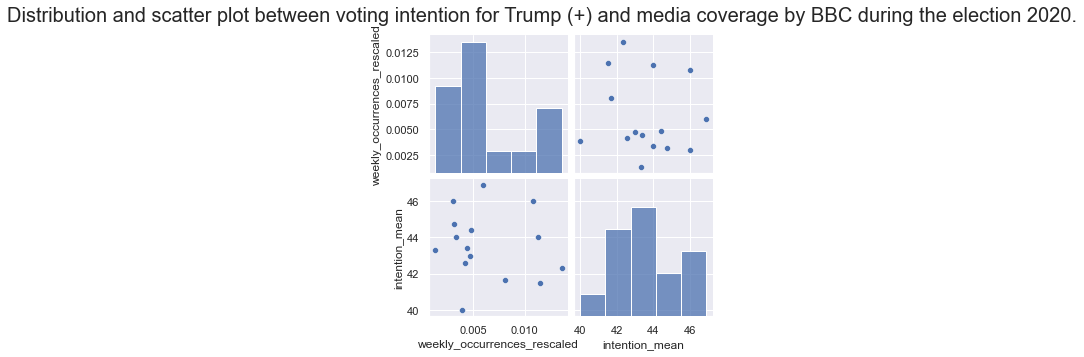

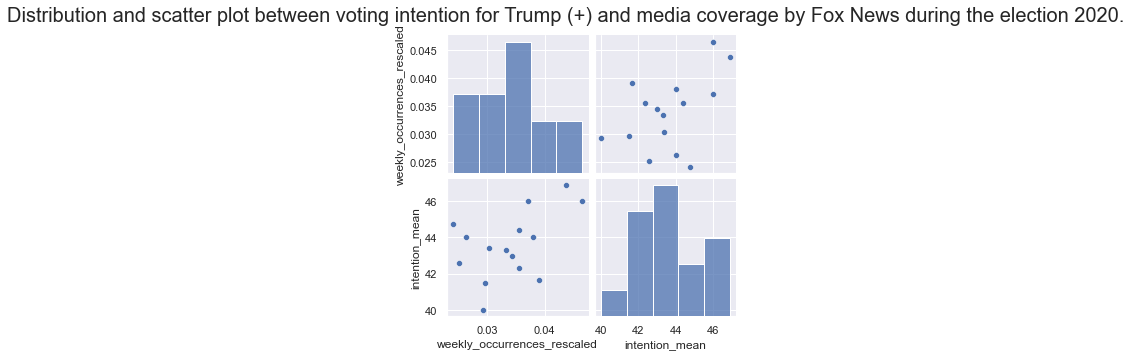

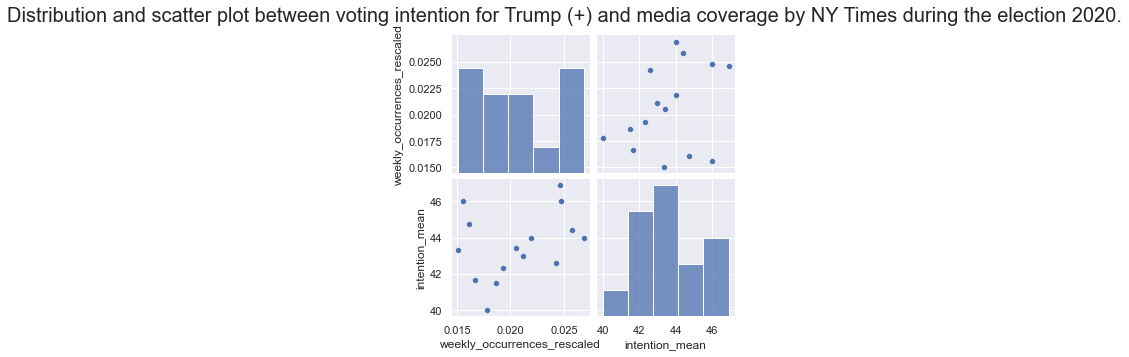

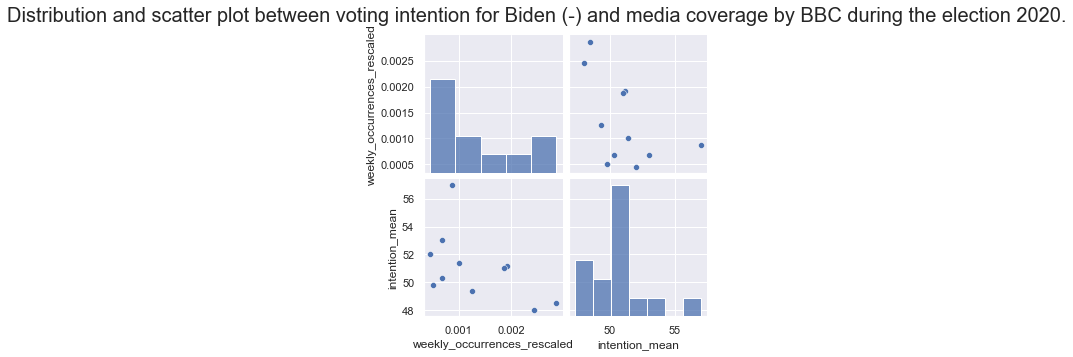

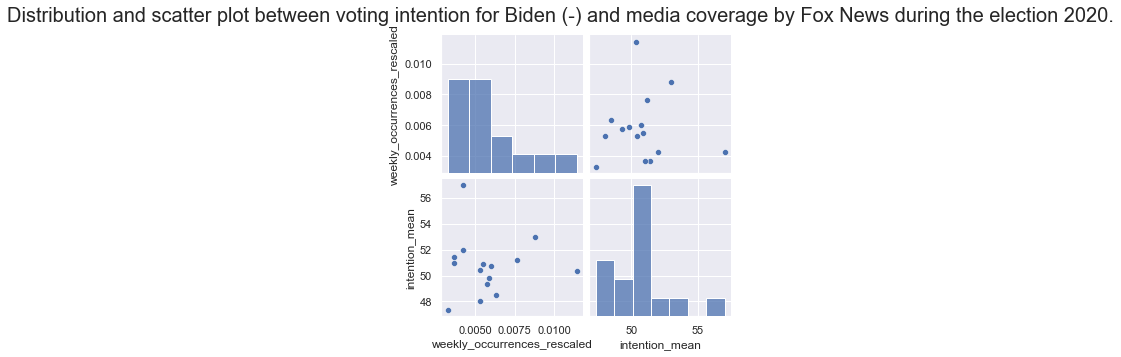

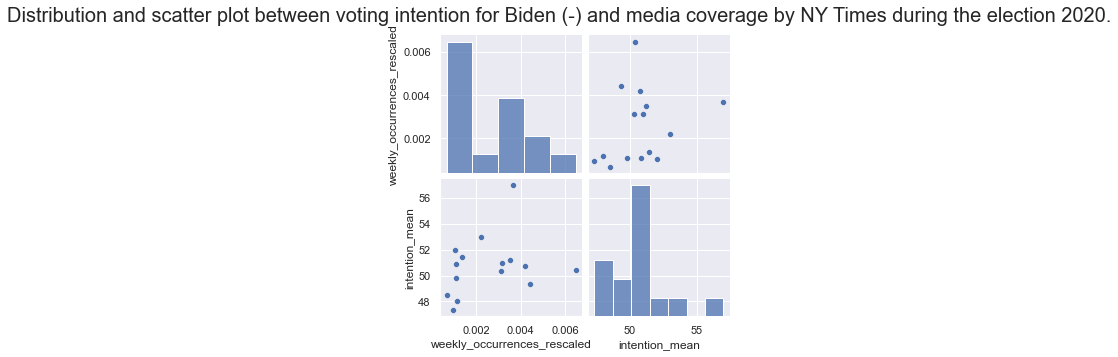

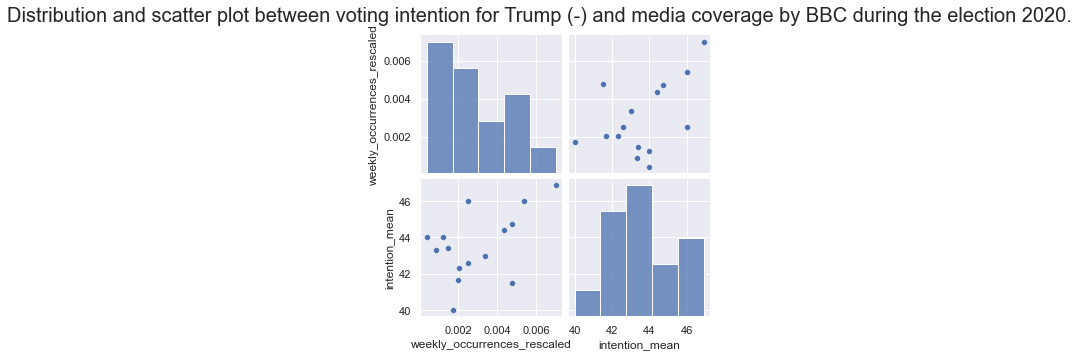

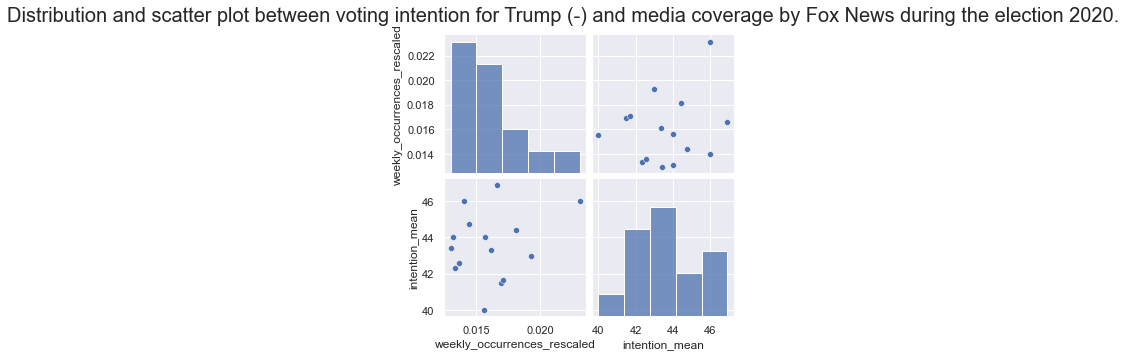

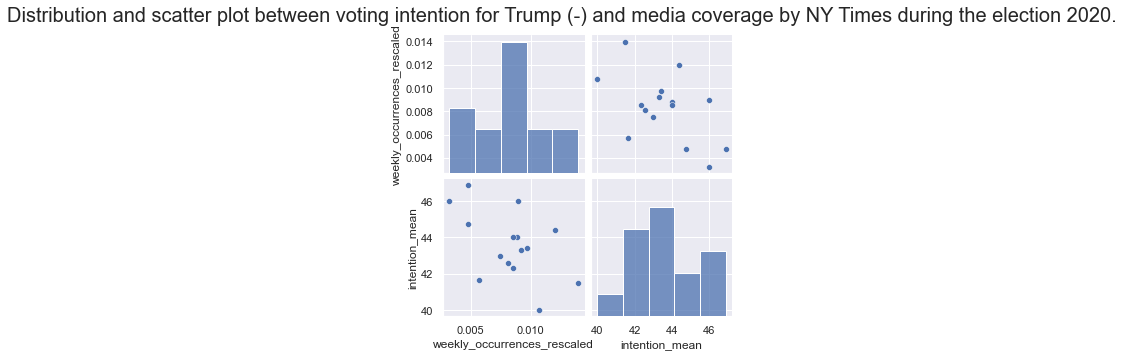

In [8]:
sns.set(font_scale=1)

for key in dict_wroi:
    df = dict_wroi[key]
    ax = sns.pairplot(df[["weekly_occurrences_rescaled", "intention_mean"]])
    ax.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
    ax.fig.suptitle(
        f"Distribution and scatter plot between voting intention for {key[1]} and media coverage by {key[2]} during the election {key[0]}.",
        fontsize=20)
    plt.show()

In [9]:
df_correlation = pd.DataFrame(columns=["Year", "Candidate", "Newspaper", "Spearmanr", "P-value"])

for key in dict_wroi:
    df = dict_wroi[key]
    row = baseline_model(df)
    row["Year"] = key[0]
    row["Candidate"] = key[1]
    row["Newspaper"] = key[2]
    df_correlation = df_correlation.append(row, ignore_index=True)

df_correlation

,Year,Candidate,Newspaper,Spearmanr,P-value
0,2012,Obama (+),BBC,0.072199,0.641404
1,2012,Obama (+),Fox News,-0.240111,0.112122
2,2012,Obama (+),NY Times,0.087487,0.567686
3,2012,Romney (+),BBC,0.264426,0.079208
4,2012,Romney (+),Fox News,0.446136,0.002129
5,2012,Romney (+),NY Times,0.317680,0.033460
6,2012,Obama (-),BBC,-0.163310,0.307622
7,2012,Obama (-),Fox News,-0.059533,0.697670
8,2012,Obama (-),NY Times,-0.013449,0.930126
9,2012,Romney (-),BBC,0.208799,0.168674


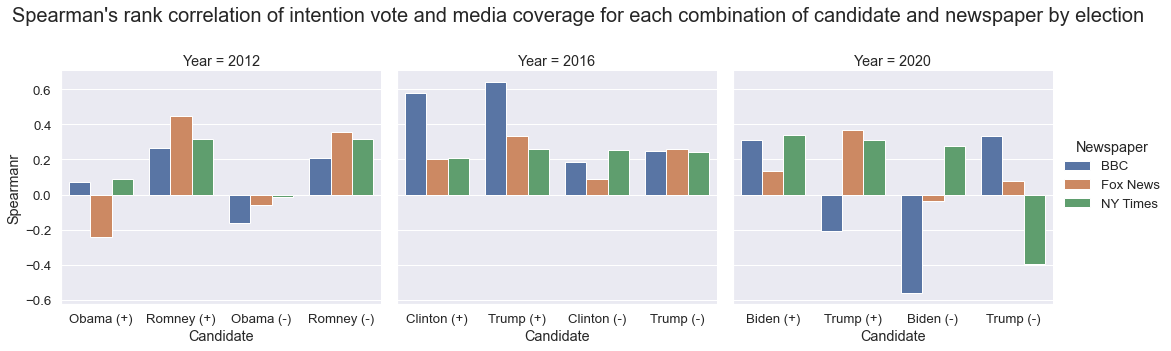

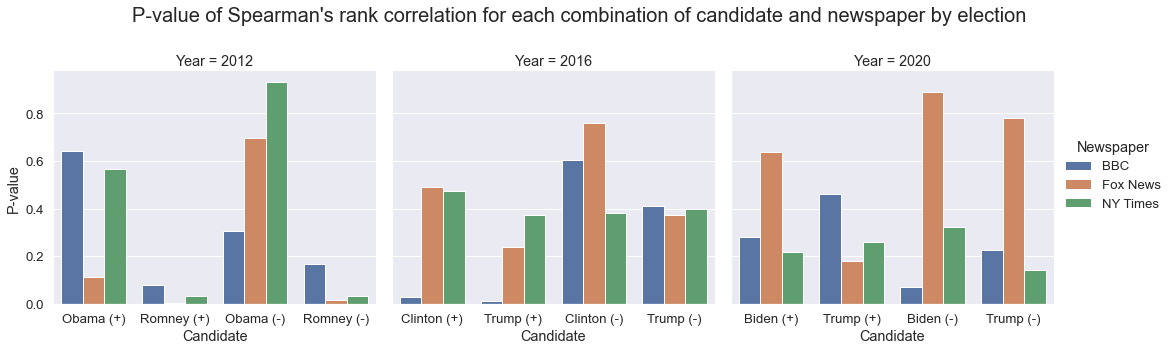

In [10]:
plot_combination("Spearmanr",
                 "Spearman's rank correlation of intention vote and media coverage for each combination of candidate and newspaper by election")
plot_combination("P-value",
                 "P-value of Spearman's rank correlation for each combination of candidate and newspaper by election")